I have identified mouse brain cell type-specific protein coding genes with pairwise dN/dS calculated from 93 mammalian species against human reference genome. Now I want to know which cell types have significantly higher dN/dS. This script calcuated these statistics. 

In [1]:
import numpy as np
import pandas as pd
import glob

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
pd.set_option('display.max_rows', 10)

# Representitive species pairwise dN/dS against mouse reference genome

In [4]:
from scipy import stats
import heapq

In [5]:
species_list=['human','rat','opposum','megabat','tasmaniandevil','cat','pig','avg_93species']
celltype_list=['neuron','endothelia','glia','astrocyte','microglia','oligodendrocyte']

### Descriptive Statistics: median and confidence interval

In [7]:
full_dict = {} # This dictionary stores dataframes for later use 
descriptive_stats_df = pd.DataFrame(
    columns=['Species','Celltype','Median_dNdS',
             'Confidence_Interval_Low','Confidence_Interval_High'])
for species in species_list:
    full_dict[species] = {}
    for celltype in celltype_list:
        df=pd.read_csv('../results/mouse.celltype-specific_genes/protein-coding_w_dNdS/'+species+'/'+celltype+'.tsv',
                       index_col=0, sep='\t')
        full_dict[species][celltype]=df
        arr=df.iloc[:,0].dropna().values
        med=np.median(arr)
        low = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[0]
        high = stats.binom.interval(alpha=.95,n=arr.shape[0],p=.5)[1]
        CI_low = heapq.nsmallest(low.astype(int),arr)[-1]
        CI_high = heapq.nsmallest(high.astype(int),arr)[-1]
        descriptive_stats_df = descriptive_stats_df.append(
            {'Species':species,'Celltype':celltype,'Median_dNdS':med,
             'Confidence_Interval_Low':CI_low,'Confidence_Interval_High':CI_high},
            ignore_index=True)


In [68]:
# create an excel file to write descriptive stats
# future analysis with other reference genome can be added to this as a new tab:

# from openpyxl import load_workbook

# book = load_workbook(path)
# writer = pd.ExcelWriter(path, engine = 'openpyxl') # note the engine
# writer.book = book

# some_df.to_excel(writer, sheet_name = 'some_sheet_name')

# writer.save()
# writer.close()

path = '../results/celltype-specific_descriptive_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

descriptive_stats_df.to_excel(writer, sheet_name = 'mouse reference genome')

writer.save()
writer.close()


### Inferential statistics: Kruskal Wallis H and Mann Whitney U between celltypes

In [8]:
inferential_stats_df=pd.DataFrame(
    columns=['Species','Kruskal H NEG','Kruskal p NEG',
             'Kruskal H NEAMO','Kruskal p NEAMO',
            'Mann U NG','Mann p NG'])

for species in species_list:

    h_NEG,kp_NEG=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['glia'])

    h_NEAMO,kp_NEAMO=stats.kruskal(
        full_dict[species]['neuron'],
        full_dict[species]['endothelia'],
        full_dict[species]['astrocyte'],
        full_dict[species]['microglia'],
        full_dict[species]['oligodendrocyte'])
    
    # June 18, 2020: debug on Jan_20_2020-Confirming_w_Couple_Species-Ensembl98Mouse
    # June 24, 2020: debug stats.mannwhitneyu(), include alternative="two-sided", 
    # default "None" is deprecated and generate a smaller p value
    # Now avoid nan values influencing test results.
    # U statistics and p values from Mann Whitney's U test 
    # comparing Neuron-specific genes and Glia-specific genes' dN/dS ratios
    u_NG, mp_NG=stats.mannwhitneyu(
        full_dict[species]['neuron'],
        full_dict[species]['glia'],
        alternative="two-sided")
    
    inferential_stats_df = inferential_stats_df.append(
            {'Species':species,'Kruskal H NEG':h_NEG,'Kruskal p NEG':kp_NEG,
            'Kruskal H NEAMO':h_NEAMO,'Kruskal p NEAMO':kp_NEAMO,
            'Mann U NG':u_NG,'Mann p NG':mp_NG},
            ignore_index=True)

In [9]:
# Create and write to excel file for inferential stats
path = '../results/celltype-specific_inferential_stats.xlsx'
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')

inferential_stats_df.to_excel(writer, sheet_name = 'mouse reference genome')

writer.save()
writer.close()

# Visualization

In [ ]:
# import statsmodels.api as sm
# import matplotlib.ticker as mtick

In [79]:
import matplotlib
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import seaborn as sns

In [77]:
matplotlib.rcParams['figure.dpi']= 300

In [82]:
from copy import deepcopy

In [170]:
graph_dict = deepcopy(full_dict)
graph_df = pd.DataFrame(columns=['dNdS','Species','Celltype'])
for celltype in celltype_list:
    for species in species_list:
        graph_dict[species][celltype].columns=['dNdS']
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Species=species)
        graph_dict[species][celltype]=graph_dict[species][celltype].assign(Celltype=celltype)
        graph_df=graph_df.append(graph_dict[species][celltype][['dNdS','Species','Celltype']],ignore_index=True)

In [129]:
sns.set_style('ticks')

In [150]:
palette={'endothelia':'tab:blue','glia':'tab:green','neuron':'tab:red','oligodendrocyte':'lightblue','astrocyte':'lightgreen','microglia':'tab:orange'}

In [208]:
for species in species_list:
    data=graph_df[graph_df['Species']==species]
    fig = plt.figure(figsize=(10,7.5))
    ax = fig.add_subplot()
    ax = sns.boxplot(y="dNdS", x="Celltype", data=data,showfliers=False,palette=palette)
    ax.set_yscale('log')
    ax.set_ylim(0.0005,1)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    sns.despine()
    stats = add_stat_annotation(ax=ax,data=data,x="Celltype", y="dNdS",
                        box_pairs=[("endothelia", "neuron"),
                                   ("endothelia", "glia"),
                                   ("glia","neuron"),
                                   ("astrocyte","neuron"),
                                   ("microglia","neuron"),
                                   ("oligodendrocyte","neuron"),
                                   ("astrocyte","microglia"),
                                   ("microglia","oligodendrocyte"),
                                   ("astrocyte","oligodendrocyte")],
                        test='Mann-Whitney', text_format='star',
                        loc='outside', verbose=2)
    pd.DataFrame(stats[1]).to_csv('../results/mouse.celltype-specific_genes/protein-coding_w_dNdS/MannWhitney/'+species+'.tsv',sep='\t',index=False)
    ax.set_xlabel("Cell Types")
    ax.set_ylabel("dN/dS of Cell Type-specific Genes")
    plt.savefig('../figures/MannWhitney/mouse_reference_genome/'+species+'.pdf')
    plt.close()

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.862e-33 U_stat=3.146e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=8.239e-01 U_stat=4.182e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=4.510e-10 U_stat=2.697e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.572e-15 U_stat=2.541e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.650e-37 U_stat=4.093e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.490e-02 U_stat=1.841e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.718e-14 U_stat=3.404e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.521e-46 U_stat=3.200e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.71

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=1.979e-21 U_stat=3.297e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=3.888e-01 U_stat=4.237e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.783e-12 U_stat=2.700e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.655e-21 U_stat=2.803e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.711e-29 U_stat=4.210e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.270e-04 U_stat=1.899e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.991e-10 U_stat=3.311e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=5.127e-42 U_stat=3.268e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.07

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=2.756e-15 U_stat=2.633e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.237e-01 U_stat=3.136e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=6.053e-02 U_stat=2.219e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=5.420e-04 U_stat=1.696e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.509e-11 U_stat=3.576e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.090e-02 U_stat=1.415e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.801e-07 U_stat=2.726e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.898e-12 U_stat=2.928e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.26

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=4.403e-12 U_stat=8.307e+04
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=7.255e-01 U_stat=1.136e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.030e-03 U_stat=7.551e+04
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.254e-11 U_stat=7.246e+04
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=1.021e-15 U_stat=1.070e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.709e-04 U_stat=4.684e+04
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.131e-10 U_stat=7.123e+04
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=9.761e-24 U_stat=8.482e+04
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.16

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=2.632e-17 U_stat=2.218e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=7.556e-01 U_stat=2.800e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=4.268e-02 U_stat=1.964e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.891e-04 U_stat=1.598e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.841e-18 U_stat=2.907e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.643e-02 U_stat=1.234e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=4.971e-12 U_stat=2.088e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.832e-19 U_stat=2.396e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.19

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=9.887e-33 U_stat=2.880e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.307e-01 U_stat=3.906e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.593e-09 U_stat=2.514e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.410e-16 U_stat=2.397e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.151e-36 U_stat=3.742e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.560e-03 U_stat=1.760e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.364e-13 U_stat=3.141e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.938e-43 U_stat=2.956e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=6.58

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=5.878e-34 U_stat=2.816e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.929e-01 U_stat=3.727e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=1.558e-09 U_stat=2.438e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.978e-15 U_stat=2.395e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=2.286e-40 U_stat=3.581e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.615e-03 U_stat=1.715e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=7.699e-16 U_stat=2.987e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=2.089e-47 U_stat=2.866e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.44

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

(0.0005, 1)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

neuron v.s. endothelia: Mann-Whitney-Wilcoxon test two-sided P_val=2.325e-40 U_stat=4.079e+05
endothelia v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=7.193e-01 U_stat=5.725e+05
astrocyte v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=4.683e-14 U_stat=3.491e+05
microglia v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=1.052e-24 U_stat=3.643e+05
neuron v.s. glia: Mann-Whitney-Wilcoxon test two-sided P_val=6.555e-43 U_stat=5.369e+05
astrocyte v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=2.060e-04 U_stat=2.404e+05
neuron v.s. astrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=5.749e-16 U_stat=4.234e+05
neuron v.s. microglia: Mann-Whitney-Wilcoxon test two-sided P_val=7.102e-59 U_stat=4.228e+05
neuron v.s. oligodendrocyte: Mann-Whitney-Wilcoxon test two-sided P_val=9.07

Text(0.5, 183.5, 'Cell Types')

Text(229.85864318847658, 0.5, 'dN/dS of Cell Type-specific Genes')

[None]

(0.0005, 1)

[Text(0, 0, 'human'),
 Text(0, 0, 'rat'),
 Text(0, 0, 'opposum'),
 Text(0, 0, 'megabat'),
 Text(0, 0, 'tasmaniandevil'),
 Text(0, 0, 'cat'),
 Text(0, 0, 'pig'),
 Text(0, 0, 'avg_93species')]

Text(0.5, 0, 'Species compared against mouse reference genome')

Text(0, 0.5, 'dN/dS of Cell Type-specific Genes')

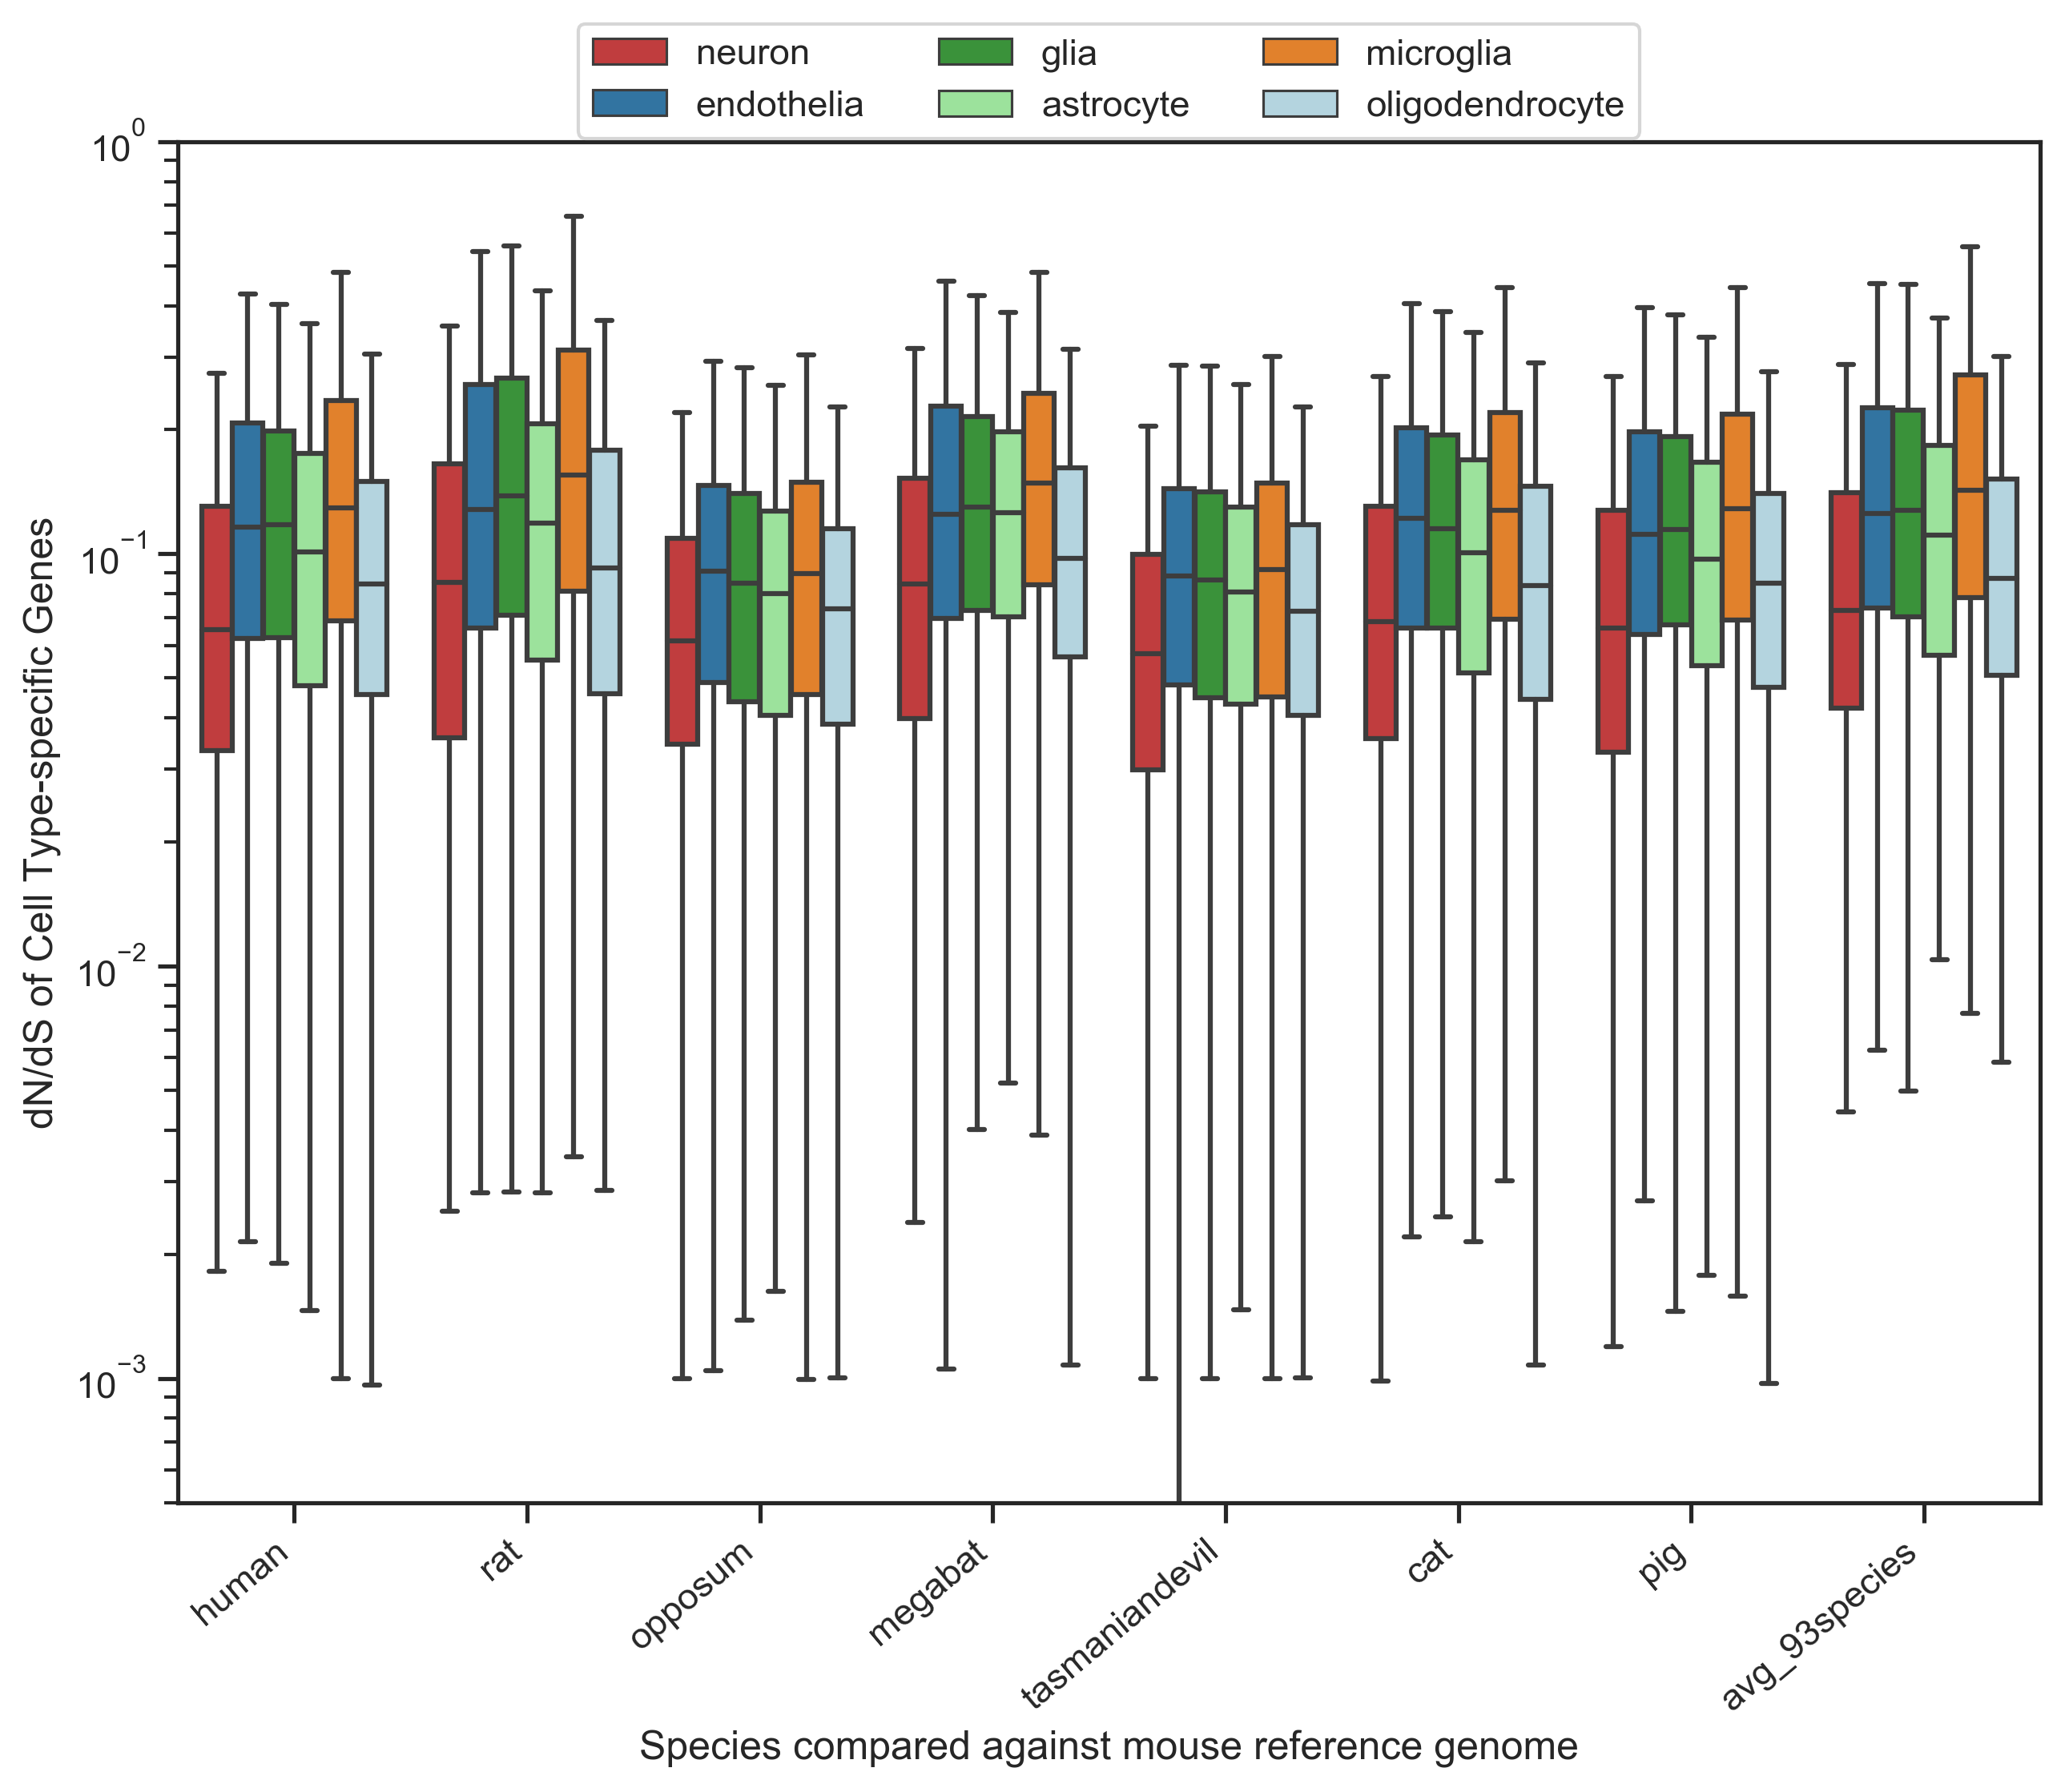

In [213]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot()
ax = sns.boxplot(x="Species", y="dNdS", hue="Celltype", data=graph_df, showfliers=False, palette=palette)
ax.set(yscale='log')
ax.set_ylim(0.0005,1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.1),ncol=3)
ax.set_xlabel("Species compared against mouse reference genome")
ax.set_ylabel("dN/dS of Cell Type-specific Genes")
plt.savefig('../figures/mouse.boxplots.pdf')
plt.show()